In [1]:
import os

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tqdm import tqdm

import warnings
warnings.simplefilter('ignore')

In [2]:
class MonetPhotoDataset(Dataset):
    def __init__(self, root_monet, root_photo, transform=None):
        self.transform = transform
        self.root_monet = root_monet
        self.root_photo = root_photo
        
        self.monet_images = os.listdir(root_monet)
        self.photo_images = os.listdir(root_photo)
        self.length_dataset = max(len(self.monet_images), len(self.photo_images))

        self.monet_len = len(self.monet_images)
        self.photo_len = len(self.photo_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, idx):
        monet_img = self.monet_images[idx % self.monet_len]
        photo_img = self.photo_images[idx % self.photo_len]
        
        monet_path = os.path.join(self.root_monet, monet_img)
        photo_path = os.path.join(self.root_photo, photo_img)
        
        monet_img = Image.open(monet_path).convert('RGB')
        photo_img = Image.open(photo_path).convert('RGB')
    
        
        monet_img = self.transform(monet_img)
        photo_img = self.transform(photo_img)
        
        return monet_img, photo_img

In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

In [4]:
dataset = MonetPhotoDataset('../input/gan-getting-started/monet_jpg', '../input/gan-getting-started/photo_jpg', transform)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
class ResBlock(nn.Module):
    def __init__(self, f):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(f, f, 3, 1, 1), 
            nn.InstanceNorm2d(f),
            nn.ReLU(),
            
            nn.Conv2d(f, f, 3, 1, 1),
        )
        
        self.norm = nn.InstanceNorm2d(f)
        
    def forward(self, x):
        return torch.relu(self.conv(x) + x)
    
class Generator(nn.Module):
    def __init__(self, f=64, res_blocks=6):
        super(Generator, self).__init__()
        layers = []
            
        layers.extend([
            nn.Conv2d(3, f, 7, 1, 3),
            nn.InstanceNorm2d(f), 
            nn.ReLU(True),

            nn.Conv2d(f, f * 2, 3, 2, 1),
            nn.InstanceNorm2d(f * 2),
            nn.ReLU(True),

            nn.Conv2d(f * 2, f * 4, 3, 2, 1),
            nn.InstanceNorm2d(f * 4),
            nn.ReLU(True)
        ])
            
        for i in range(res_blocks):
            layers.append(ResBlock(f * 4))
        
        layers.extend([
            nn.ConvTranspose2d(f * 4, f * 2 * 4, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.InstanceNorm2d(f * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(f * 2, f * 4, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.InstanceNorm2d(f),
            nn.ReLU(True),
    
            nn.ReflectionPad2d(3),
            nn.Conv2d(f, 3, 7, 1, 0),
            nn.Tanh()
            
        ])
         
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super(Discriminator, self).__init__()
        self.init = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 1, 1),
            nn.InstanceNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 1),
            
            #nn.Flatten(),
            #nn.Linear(30 * 30, 1),
            nn.Sigmoid()
            
        )

    def forward(self, x):
        output = self.init(x)
        return output

In [8]:
disc_M = Discriminator().to(device)
disc_P = Discriminator().to(device)

gen_M = Generator().to(device)
gen_P = Generator().to(device)

opt_disc = torch.optim.Adam(
    list(disc_M.parameters()) + list(disc_P.parameters()),
    lr=2e-4,
    betas=(0.5, 0.999)
)

opt_gen = torch.optim.Adam(
    list(gen_M.parameters()) + list(gen_P.parameters()),
    lr=2e-4,
    betas=(0.5, 0.999)
)

l1 = nn.L1Loss()
mse = nn.MSELoss()

In [9]:
loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [10]:
num_epochs = 2

for epoch in range(num_epochs):
    loop = tqdm(loader, leave=True)
    for idx, (monet, photo) in enumerate(loop):
        monet = monet.to(device)
        photo = photo.to(device)

        fake_photo = gen_P(monet)
        D_P_real = disc_P(photo)
        D_P_fake = disc_P(fake_photo.detach())
        D_P_real_loss = mse(D_P_real, torch.ones(len(D_P_real)).to(device))
        D_P_fake_loss = mse(D_P_fake, torch.zeros(len(D_P_fake)).to(device))
        D_P_loss = D_P_real_loss + D_P_fake_loss

        fake_monet = gen_M(photo)
        D_M_real = disc_M(monet)
        D_M_fake = disc_M(fake_monet.detach())
        D_M_real_loss = mse(D_M_real, torch.ones(len(D_M_real)).to(device))
        D_M_fake_loss = mse(D_M_fake, torch.zeros(len(D_M_fake)).to(device))
        D_M_loss = D_M_real_loss + D_M_fake_loss

        D_loss = (D_P_loss + D_M_loss) / 2
        opt_disc.zero_grad()
        D_loss.backward()
        opt_disc.step()

        D_P_fake = disc_P(fake_photo)
        D_M_fake = disc_M(fake_monet)
        loss_G_P = mse(D_P_fake, torch.ones(len(D_P_fake)).to(device))
        loss_G_M = mse(D_M_fake, torch.ones(len(D_M_fake)).to(device))

        cycle_photo = gen_P(fake_monet)
        cycle_monet = gen_M(fake_photo)
        cycle_photo_loss = l1(photo, cycle_photo)
        cycle_monet_loss = l1(monet, cycle_monet)

        identity_photo = gen_P(photo)
        identity_monet = gen_M(monet)
        identity_photo_loss = l1(photo, identity_photo)
        identity_monet_loss = l1(monet, identity_monet)

        G_loss = (
            loss_G_P 
            + loss_G_M 
            + cycle_photo_loss * 10
            + cycle_monet_loss * 10
            + identity_photo_loss
            + identity_monet_loss
        )

        opt_gen.zero_grad()
        G_loss.backward()
        opt_gen.step()
        
        if idx % 200 == 0:
            print(
                'G_P_loss:', loss_G_P.cpu().detach().item(), 
                'G_M_loss:', loss_G_M.cpu().detach().item(), 
                'D_M_loss:', D_M_loss.cpu().detach().item(), 
                'D_P_loss:', D_P_loss.cpu().detach().item()
            )

  0%|          | 1/7038 [00:05<9:59:27,  5.11s/it]

G_P_loss: 0.2483242303133011 G_M_loss: 0.3352595567703247 D_M_loss: 0.542601466178894 D_P_loss: 0.524596631526947


  3%|▎         | 201/7038 [00:52<28:13,  4.04it/s]

G_P_loss: 0.37577107548713684 G_M_loss: 0.3137013912200928 D_M_loss: 0.43165287375450134 D_P_loss: 0.5893592834472656


  6%|▌         | 401/7038 [01:39<27:21,  4.04it/s]

G_P_loss: 0.5253637433052063 G_M_loss: 0.6063482761383057 D_M_loss: 0.18274399638175964 D_P_loss: 0.37935301661491394


  9%|▊         | 601/7038 [02:27<26:31,  4.04it/s]

G_P_loss: 0.48827889561653137 G_M_loss: 0.34747061133384705 D_M_loss: 0.4168980121612549 D_P_loss: 0.33129432797431946


 11%|█▏        | 801/7038 [03:14<25:42,  4.04it/s]

G_P_loss: 0.5409512519836426 G_M_loss: 0.3791196644306183 D_M_loss: 0.5023868083953857 D_P_loss: 0.30138760805130005


 14%|█▍        | 1001/7038 [04:01<24:54,  4.04it/s]

G_P_loss: 0.6658307313919067 G_M_loss: 0.6039950847625732 D_M_loss: 0.22701317071914673 D_P_loss: 0.15212421119213104


 17%|█▋        | 1201/7038 [04:48<24:03,  4.04it/s]

G_P_loss: 0.49921271204948425 G_M_loss: 0.3035145699977875 D_M_loss: 0.6210035085678101 D_P_loss: 0.30882203578948975


 20%|█▉        | 1401/7038 [05:36<23:20,  4.02it/s]

G_P_loss: 0.4761599600315094 G_M_loss: 0.528947114944458 D_M_loss: 0.38981249928474426 D_P_loss: 0.3996579349040985


 23%|██▎       | 1601/7038 [06:23<22:25,  4.04it/s]

G_P_loss: 0.8195201754570007 G_M_loss: 0.7593157291412354 D_M_loss: 0.12053388357162476 D_P_loss: 0.05879812315106392


 26%|██▌       | 1801/7038 [07:10<21:34,  4.05it/s]

G_P_loss: 0.7020201683044434 G_M_loss: 0.5373451113700867 D_M_loss: 0.21228821575641632 D_P_loss: 0.5757741332054138


 28%|██▊       | 2001/7038 [07:58<20:45,  4.04it/s]

G_P_loss: 0.45687246322631836 G_M_loss: 0.5312371253967285 D_M_loss: 0.33063915371894836 D_P_loss: 0.3047747313976288


 31%|███▏      | 2201/7038 [08:45<20:01,  4.02it/s]

G_P_loss: 0.3642787039279938 G_M_loss: 0.723979115486145 D_M_loss: 0.10107351839542389 D_P_loss: 0.434998482465744


 34%|███▍      | 2401/7038 [09:32<19:07,  4.04it/s]

G_P_loss: 0.398342102766037 G_M_loss: 0.4138268530368805 D_M_loss: 0.3390519917011261 D_P_loss: 0.32251566648483276


 37%|███▋      | 2601/7038 [10:20<18:16,  4.05it/s]

G_P_loss: 0.419577956199646 G_M_loss: 0.5012549757957458 D_M_loss: 0.3957456350326538 D_P_loss: 0.34771594405174255


 40%|███▉      | 2801/7038 [11:07<17:29,  4.04it/s]

G_P_loss: 0.43702903389930725 G_M_loss: 0.37352821230888367 D_M_loss: 0.4731728136539459 D_P_loss: 0.5223121643066406


 43%|████▎     | 3001/7038 [11:55<18:00,  3.74it/s]

G_P_loss: 0.5503380298614502 G_M_loss: 0.5601411461830139 D_M_loss: 0.21698328852653503 D_P_loss: 0.26054349541664124


 45%|████▌     | 3201/7038 [12:42<15:48,  4.04it/s]

G_P_loss: 0.3335970342159271 G_M_loss: 0.21284888684749603 D_M_loss: 1.0285383462905884 D_P_loss: 0.593501091003418


 48%|████▊     | 3401/7038 [13:29<14:59,  4.04it/s]

G_P_loss: 0.4458640515804291 G_M_loss: 0.5049651861190796 D_M_loss: 0.517287015914917 D_P_loss: 0.31119075417518616


 51%|█████     | 3601/7038 [14:17<14:09,  4.05it/s]

G_P_loss: 0.4560109078884125 G_M_loss: 0.42846089601516724 D_M_loss: 0.37559768557548523 D_P_loss: 0.31849759817123413


 54%|█████▍    | 3801/7038 [15:04<13:20,  4.05it/s]

G_P_loss: 0.5136166214942932 G_M_loss: 0.5886265635490417 D_M_loss: 0.26035141944885254 D_P_loss: 0.20726674795150757


 57%|█████▋    | 4001/7038 [15:52<12:31,  4.04it/s]

G_P_loss: 0.42327260971069336 G_M_loss: 0.5906633734703064 D_M_loss: 0.698968768119812 D_P_loss: 0.3882845640182495


 60%|█████▉    | 4201/7038 [16:39<11:41,  4.04it/s]

G_P_loss: 0.33294445276260376 G_M_loss: 0.644698977470398 D_M_loss: 0.25414595007896423 D_P_loss: 0.5513914823532104


 63%|██████▎   | 4401/7038 [17:27<10:57,  4.01it/s]

G_P_loss: 0.3473249077796936 G_M_loss: 0.47805681824684143 D_M_loss: 0.38299259543418884 D_P_loss: 0.4773861765861511


 65%|██████▌   | 4601/7038 [18:14<10:02,  4.04it/s]

G_P_loss: 0.46063411235809326 G_M_loss: 0.6915748715400696 D_M_loss: 0.11522552371025085 D_P_loss: 0.39905256032943726


 68%|██████▊   | 4801/7038 [19:01<09:23,  3.97it/s]

G_P_loss: 0.5836541652679443 G_M_loss: 0.6517910361289978 D_M_loss: 0.1888643205165863 D_P_loss: 0.5512354969978333


 71%|███████   | 5001/7038 [19:49<08:23,  4.04it/s]

G_P_loss: 0.38950327038764954 G_M_loss: 0.4954107999801636 D_M_loss: 0.46559464931488037 D_P_loss: 0.48658275604248047


 74%|███████▍  | 5201/7038 [20:36<07:33,  4.05it/s]

G_P_loss: 0.5729466676712036 G_M_loss: 0.5932531356811523 D_M_loss: 0.43615230917930603 D_P_loss: 0.14314110577106476


 77%|███████▋  | 5401/7038 [21:24<06:45,  4.04it/s]

G_P_loss: 0.44791004061698914 G_M_loss: 0.4464007019996643 D_M_loss: 0.4535048007965088 D_P_loss: 0.3575896620750427


 80%|███████▉  | 5601/7038 [22:11<05:55,  4.05it/s]

G_P_loss: 0.41504064202308655 G_M_loss: 0.6760827898979187 D_M_loss: 0.1492273211479187 D_P_loss: 0.3620668053627014


 82%|████████▏ | 5801/7038 [22:58<05:07,  4.02it/s]

G_P_loss: 0.4068540632724762 G_M_loss: 0.6376978754997253 D_M_loss: 0.18828824162483215 D_P_loss: 0.46387800574302673


 85%|████████▌ | 6001/7038 [23:45<04:16,  4.05it/s]

G_P_loss: 0.509694516658783 G_M_loss: 0.7798422574996948 D_M_loss: 0.0938546434044838 D_P_loss: 0.20543226599693298


 88%|████████▊ | 6201/7038 [24:33<03:27,  4.04it/s]

G_P_loss: 0.5611043572425842 G_M_loss: 0.5069469809532166 D_M_loss: 0.3414797782897949 D_P_loss: 0.21712616086006165


 91%|█████████ | 6401/7038 [25:20<02:37,  4.05it/s]

G_P_loss: 0.6626186966896057 G_M_loss: 0.6206203103065491 D_M_loss: 0.8243127465248108 D_P_loss: 0.12824681401252747


 94%|█████████▍| 6601/7038 [26:08<01:48,  4.04it/s]

G_P_loss: 0.4832170307636261 G_M_loss: 0.32985955476760864 D_M_loss: 0.5512423515319824 D_P_loss: 0.47343316674232483


 97%|█████████▋| 6801/7038 [26:55<00:59,  4.02it/s]

G_P_loss: 0.4950830936431885 G_M_loss: 0.5640232563018799 D_M_loss: 0.37988585233688354 D_P_loss: 0.19436050951480865


 99%|█████████▉| 7001/7038 [27:43<00:09,  4.05it/s]

G_P_loss: 0.5028960108757019 G_M_loss: 0.48685306310653687 D_M_loss: 0.45944443345069885 D_P_loss: 0.5892192125320435


  0%|          | 1/7038 [00:00<31:25,  3.73it/s]

G_P_loss: 0.37901267409324646 G_M_loss: 0.4911363422870636 D_M_loss: 0.3259029686450958 D_P_loss: 0.38371461629867554


  3%|▎         | 201/7038 [00:47<28:13,  4.04it/s]

G_P_loss: 0.6396178007125854 G_M_loss: 0.6061046123504639 D_M_loss: 0.3153821527957916 D_P_loss: 0.0919627770781517


  6%|▌         | 401/7038 [01:34<27:20,  4.05it/s]

G_P_loss: 0.27780160307884216 G_M_loss: 0.4879659116268158 D_M_loss: 0.38800132274627686 D_P_loss: 0.7639006972312927


  9%|▊         | 601/7038 [02:22<26:32,  4.04it/s]

G_P_loss: 0.5367206335067749 G_M_loss: 0.6207535862922668 D_M_loss: 0.2147340476512909 D_P_loss: 0.2005891054868698


 11%|█▏        | 801/7038 [03:09<25:40,  4.05it/s]

G_P_loss: 0.6108701825141907 G_M_loss: 0.8618803024291992 D_M_loss: 0.07607415318489075 D_P_loss: 0.28782880306243896


 14%|█▍        | 1001/7038 [03:56<24:52,  4.04it/s]

G_P_loss: 0.374749094247818 G_M_loss: 0.6764461398124695 D_M_loss: 0.12400244921445847 D_P_loss: 0.3810044527053833


 17%|█▋        | 1201/7038 [04:44<24:04,  4.04it/s]

G_P_loss: 0.4669690728187561 G_M_loss: 0.7846447825431824 D_M_loss: 0.24056805670261383 D_P_loss: 0.4198063611984253


 20%|█▉        | 1401/7038 [05:31<23:13,  4.04it/s]

G_P_loss: 0.3430973291397095 G_M_loss: 0.7997204065322876 D_M_loss: 0.15243148803710938 D_P_loss: 0.6297478675842285


 23%|██▎       | 1601/7038 [06:18<22:23,  4.05it/s]

G_P_loss: 0.5454900860786438 G_M_loss: 0.8651579022407532 D_M_loss: 0.08142267167568207 D_P_loss: 0.25723761320114136


 26%|██▌       | 1801/7038 [07:06<21:37,  4.04it/s]

G_P_loss: 0.6030431985855103 G_M_loss: 0.9300689101219177 D_M_loss: 0.007225894834846258 D_P_loss: 0.20211538672447205


 28%|██▊       | 2001/7038 [07:53<20:46,  4.04it/s]

G_P_loss: 0.5259133577346802 G_M_loss: 0.816548228263855 D_M_loss: 0.2052846997976303 D_P_loss: 0.7092231512069702


 31%|███▏      | 2201/7038 [08:40<19:57,  4.04it/s]

G_P_loss: 0.3608217239379883 G_M_loss: 0.8558647036552429 D_M_loss: 0.17221307754516602 D_P_loss: 0.45125284790992737


 34%|███▍      | 2401/7038 [09:28<19:05,  4.05it/s]

G_P_loss: 0.348332941532135 G_M_loss: 0.9274837374687195 D_M_loss: 0.010169037617743015 D_P_loss: 0.39414167404174805


 37%|███▋      | 2601/7038 [10:15<18:17,  4.04it/s]

G_P_loss: 0.5727322101593018 G_M_loss: 0.8863224387168884 D_M_loss: 0.09413617849349976 D_P_loss: 0.21795213222503662


 40%|███▉      | 2801/7038 [11:02<17:27,  4.04it/s]

G_P_loss: 0.447153776884079 G_M_loss: 0.9642661213874817 D_M_loss: 0.005011012777686119 D_P_loss: 0.24292147159576416


 43%|████▎     | 3001/7038 [11:50<16:37,  4.05it/s]

G_P_loss: 0.37948161363601685 G_M_loss: 0.8546629548072815 D_M_loss: 0.024363189935684204 D_P_loss: 0.4935130476951599


 45%|████▌     | 3201/7038 [12:37<16:00,  3.99it/s]

G_P_loss: 0.4584112763404846 G_M_loss: 0.9224584698677063 D_M_loss: 0.045860812067985535 D_P_loss: 0.3360779881477356


 48%|████▊     | 3401/7038 [13:24<14:59,  4.05it/s]

G_P_loss: 0.53081876039505 G_M_loss: 0.9954737424850464 D_M_loss: 0.020030083134770393 D_P_loss: 0.19635653495788574


 51%|█████     | 3601/7038 [14:12<14:10,  4.04it/s]

G_P_loss: 0.42950183153152466 G_M_loss: 0.9953315258026123 D_M_loss: 0.00029563665157184005 D_P_loss: 0.32895582914352417


 54%|█████▍    | 3801/7038 [14:59<13:31,  3.99it/s]

G_P_loss: 0.6356102228164673 G_M_loss: 0.9866029024124146 D_M_loss: 0.004769168794155121 D_P_loss: 0.09668471664190292


 57%|█████▋    | 4001/7038 [15:47<12:30,  4.05it/s]

G_P_loss: 0.36378011107444763 G_M_loss: 0.9610194563865662 D_M_loss: 0.5003302097320557 D_P_loss: 0.46059203147888184


 60%|█████▉    | 4201/7038 [16:34<11:41,  4.04it/s]

G_P_loss: 0.5552470088005066 G_M_loss: 0.9934965372085571 D_M_loss: 0.0038855113089084625 D_P_loss: 0.3891579806804657


 63%|██████▎   | 4401/7038 [17:21<10:53,  4.04it/s]

G_P_loss: 0.3712507486343384 G_M_loss: 0.9559575319290161 D_M_loss: 0.025707827880978584 D_P_loss: 0.6017695069313049


 65%|██████▌   | 4601/7038 [18:09<10:02,  4.05it/s]

G_P_loss: 0.5315525531768799 G_M_loss: 0.9277393221855164 D_M_loss: 0.02520364709198475 D_P_loss: 0.2559374272823334


 68%|██████▊   | 4801/7038 [18:56<09:13,  4.04it/s]

G_P_loss: 0.36521029472351074 G_M_loss: 0.9937350749969482 D_M_loss: 0.0004012232820969075 D_P_loss: 0.38148033618927


 71%|███████   | 5001/7038 [19:43<08:23,  4.05it/s]

G_P_loss: 0.607342004776001 G_M_loss: 0.9367814064025879 D_M_loss: 0.021683113649487495 D_P_loss: 0.1817651391029358


 74%|███████▍  | 5201/7038 [20:31<07:34,  4.04it/s]

G_P_loss: 0.7654876112937927 G_M_loss: 0.9984047412872314 D_M_loss: 0.0009015845716930926 D_P_loss: 0.09566816687583923


 77%|███████▋  | 5401/7038 [21:18<06:45,  4.04it/s]

G_P_loss: 0.45165976881980896 G_M_loss: 0.9971491694450378 D_M_loss: 0.010198935866355896 D_P_loss: 0.5355122089385986


 80%|███████▉  | 5601/7038 [22:05<05:55,  4.05it/s]

G_P_loss: 0.5033256411552429 G_M_loss: 0.9610553979873657 D_M_loss: 0.014079872518777847 D_P_loss: 0.1788317859172821


 82%|████████▏ | 5801/7038 [22:52<05:07,  4.02it/s]

G_P_loss: 0.47477495670318604 G_M_loss: 0.981773316860199 D_M_loss: 0.0003002192825078964 D_P_loss: 0.31607601046562195


 85%|████████▌ | 6001/7038 [23:40<04:16,  4.05it/s]

G_P_loss: 0.5561738014221191 G_M_loss: 0.9316051602363586 D_M_loss: 0.027873024344444275 D_P_loss: 0.18620777130126953


 88%|████████▊ | 6201/7038 [24:27<03:26,  4.05it/s]

G_P_loss: 0.3269908130168915 G_M_loss: 0.999776303768158 D_M_loss: 0.0013892236165702343 D_P_loss: 0.6335660219192505


 91%|█████████ | 6401/7038 [25:14<02:37,  4.04it/s]

G_P_loss: 0.6645219326019287 G_M_loss: 0.997429370880127 D_M_loss: 0.005382856819778681 D_P_loss: 0.10235592722892761


 94%|█████████▍| 6601/7038 [26:02<01:47,  4.05it/s]

G_P_loss: 0.6556392312049866 G_M_loss: 0.9930267333984375 D_M_loss: 0.1011323556303978 D_P_loss: 0.13200905919075012


 97%|█████████▋| 6801/7038 [26:49<00:58,  4.04it/s]

G_P_loss: 0.5610411167144775 G_M_loss: 0.9959736466407776 D_M_loss: 0.15459027886390686 D_P_loss: 0.29730576276779175


 99%|█████████▉| 7001/7038 [27:36<00:09,  4.04it/s]

G_P_loss: 0.4799366593360901 G_M_loss: 0.9810277223587036 D_M_loss: 0.02265658788383007 D_P_loss: 0.33760273456573486


100%|██████████| 7038/7038 [27:45<00:00,  4.23it/s]


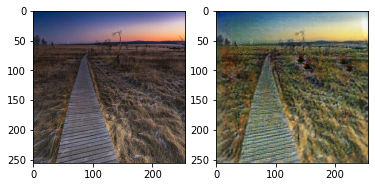

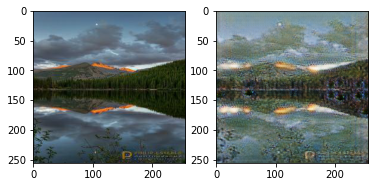

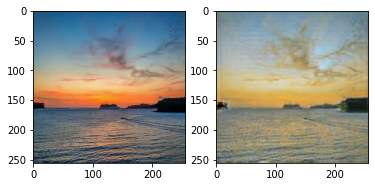

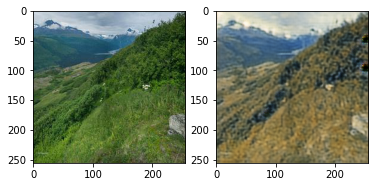

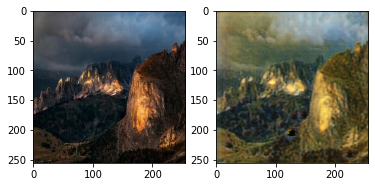

In [11]:
for idx, (monet, photo) in enumerate(loader):
    monet = monet.to(device)
    photo = photo.to(device)
    fake_photo = gen_P(monet)
    fake_monet = gen_M(photo).cpu().detach()[0]
    
    plt.subplot(121)
    plt.imshow(photo.cpu().detach()[0].squeeze().permute(1, 2, 0) * 0.5 + 0.5)
    plt.subplot(122)
    plt.imshow(fake_monet.squeeze().permute(1, 2, 0) * 0.5 + 0.5)
        
    plt.show()
        
    if idx == 4:
        break

In [12]:
import PIL
! mkdir ./images

In [13]:
import PIL
i = 1
for (monet, photo) in tqdm(dataset):
    
    photo = photo.to(device)
    prediction = gen_M(photo[None, :]).cpu().detach()[0]
    prediction = (127.5 + 127.5 * prediction).permute(1, 2, 0).numpy().astype(np.uint8)

    im = PIL.Image.fromarray(prediction)
    im.save("./images/" + str(i) + ".jpg")
    i += 1
    if i == 7005:
        break

100%|█████████▉| 7003/7038 [02:39<00:00, 43.97it/s]


In [14]:
import shutil
shutil.make_archive('/kaggle/working/images/', 'zip', '/kaggle/working/images/')

'/kaggle/working/images.zip'